# Multivariate Regression

# Show the collections that have been generated

In [1]:
from pymongo import MongoClient
from process_collection import *
#  IMPORTANT:  Set these for each run:
#################################################
# mongoServer = None   # use the local mongodb server installed on your computer
#mongoServer = 'mongodb://server.mcgarity.info:27017/'  # Art's personal server
#mongoServer = 'mongodb://ubuntu:27017/'  # ubuntu Linux virtual machine on Art's Mac
mongoServer = 'mongodb://aws-2.greenphilly.net:27017/'  # aws-2 server for GreenPhilly
database = "jcohen4"
username = "jcohen4"
password = "wingohocking"
authenticationDatabase = "jcohen4"

client = MongoClient(mongoServer)
################################################

db = client[database]
db.authenticate(username, password, source=authenticationDatabase)  # pass credentials to database
collectionNames = sorted(db.collection_names())
collectionNames

[u'2008',
 u'2008trial1',
 u'2008trial3',
 u'2008trial4',
 u'2008trial6',
 u'first_wingo_test',
 u'fourth_wingo_test',
 u'impervFixed',
 u'impervNotFixed',
 u'july',
 u'july10',
 u'july12',
 u'july13',
 u'july14',
 u'july15',
 u'july16',
 u'july17',
 u'july2',
 u'july21',
 u'july22',
 u'july23',
 u'july24',
 u'july3',
 u'july4',
 u'july5',
 u'july6',
 u'july7',
 u'july8',
 u'july9',
 u'largeTrialLinier',
 u'multivariate_250_2010',
 u'multivariate_random_250_2010',
 u'multivariate_random_250_2011',
 u'multivariate_random_250_2012',
 u'multivariate_random_250_2013',
 u'randomTrial1',
 u'randomTrial2',
 u'randomTrial4',
 u'randomTrial5',
 u'random_multivariate',
 u'random_multivariate2',
 u'random_multivariate2009',
 u'random_multivariate2009year',
 u'random_multivariate2010',
 u'random_multivariate2012year',
 u'random_multivariate250',
 u'random_multivariate250_2009',
 u'random_multivariate3',
 u'random_multivariate5',
 u'random_multivariate6',
 u'random_multivariate7',
 u'random_multiva

In [2]:
from get_cso import calculate_cso
acft_to_mgal = 0.325851  # 1 acre-ft = 0.325851 MGal
collectionName = 'y16m12d27_AEM_45_Subcat_Leeds_Tree_Trench_and_Rain_Barrel_5'
runs = db[collectionName]
cursor = runs.find()
noLidRun = cursor[0]
noLidVolume = noLidRun['volume']  # 10^6 Gal / yr
noLidPeak = noLidRun['peak']   # cfs
noLidRunoff = noLidRun['runoff']  # acre-ft/yr
outflowSeries = noLidRun['outflow_series']
ratio = 0.05
csoResults = calculate_cso(outflowSeries,ratio)
csoVolumeMGal = csoResults['cso_volume']/1e6
print "noLidPeak = %0.2f cfs, noLidVolume = %0.2f MGal" % (noLidPeak,noLidVolume)
print "noLid Runoff = %0.2f acre-ft = %0.2f MGal" % (noLidRunoff,noLidRunoff*acft_to_mgal)
print "noLid csoVolumeMGal = %0.2f MGal" % csoVolumeMGal
# NOTE: Volume is total flow volume at sewer outlet while Runoff is total runoff volume
#       so they will likely be slightly different
noLidRunParamsList = noLidRun['runParamList']
#print noLidRunParamsList

noLidPeak = 1948.45 cfs, noLidVolume = 1948.90 MGal
noLid Runoff = 5987.73 acre-ft = 1951.11 MGal
noLid csoVolumeMGal = 687.45 MGal


In [3]:
# Compute Annual CSO Flows from results stored on Mongo
from get_cso import * 
from process_collection import * 
collectionName = 'y16m12d27_AEM_45_Subcat_Leeds_Tree_Trench_and_Rain_Barrel_5'
ratio = 0.05
numSubcatch = 45
numLID = 2
numVariables = numSubcatch*numLID
results = volume_reduction_and_runoff_volume_vs_lid_number(collectionName, numVariables, db)
volReduction = results["volReductionList"]
numberOfRuns = len(volReduction)
volReductionMgal = [x / 1e6 for x in volReduction]
numberOfRuns = len(volReductionMgal)
#print volReduction
# ALERT:  in cso_reduction, collectionName and numSubCatch is never used !!!
csoResults = cso_reduction(collectionName, ratio, numSubcatch, results) 
csoReduction = csoResults["csoReduction"]
csoReductionMgal = [x / 1e6 for x in csoReduction]
#print csoReductionMgal
cso = csoResults["cso"]
#print cso
totVol = csoResults["totalVol"]
print "Number of Runs stored in Database = %d" % numberOfRuns
#print results['numLists'][0]

Number of Runs stored in Database = 743


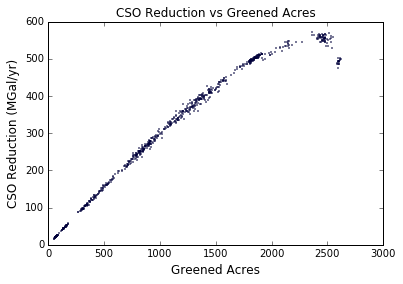

In [86]:
# Compute total greened acres and plot CSO reductions vs greened acres
%matplotlib inline
import matplotlib.pyplot as plt
gaPerLid = [0.1,0.936]
lidNumbers = results['numLists']
greenedAcres = []
lidGreenedAcres = {}
for lid in range(0,numLID):
    lidGreenedAcres[lid] = []
lidTransposed = zip(*lidNumbers)
for run in range(0,numberOfRuns):
    variable = 0
    lidList = lidTransposed[run]
    gaTotalThisRun = 0.0
    for lid in range(0,numLID):
        gaTotalThisLID = 0.0
        for subcat in range(0,numSubcatch):
            numberLID = lidList[variable]
            thisGreenedAcres = gaPerLid[lid]*numberLID
            gaTotalThisRun += thisGreenedAcres
            gaTotalThisLID += thisGreenedAcres
            variable += 1
        lidGreenedAcres[lid].append(gaTotalThisLID)
    greenedAcres.append(gaTotalThisRun)
#print greenedAcres
#print lidGreenedAcres
(fig, ax1) = plt.subplots()
plt.title("CSO Reduction vs Greened Acres")
ax1.plot(greenedAcres,csoReductionMgal,'ko',color = 'b',markersize = 1)
ax1.set_xlabel("Greened Acres",fontsize=12)
ax1.set_ylabel("CSO Reduction (MGal/yr)",fontsize=12)

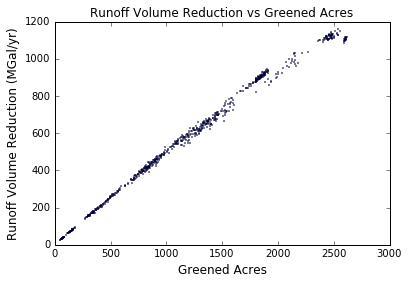

In [87]:
(fig, ax1) = plt.subplots()
plt.title("Runoff Volume Reduction vs Greened Acres")
ax1.plot(greenedAcres,volReductionMgal,'ko',color = 'b',markersize = 1)
ax1.set_xlabel("Greened Acres",fontsize=12)
ax1.set_ylabel("Runoff Volume Reduction (MGal/yr)",fontsize=12)

Total number of SWMM runs = 743


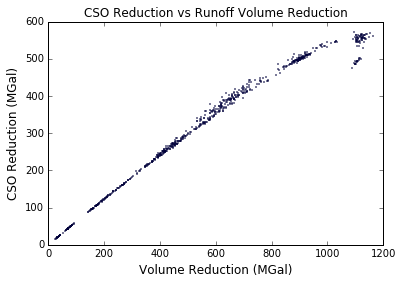

In [88]:
# SCATTER PLOT OF CSO ANNUAL VOLUME REDUCTION VS SEWER OUTFLOW ANNUAL VOLUME REDUCTION
%matplotlib inline
import matplotlib.pyplot as plt
print "Total number of SWMM runs = %d" % len(volReductionMgal)
#xRange = [50,70]
#yRange = [25,45]
(fig, ax1) = plt.subplots()
ax1.plot(volReductionMgal,csoReductionMgal,'ko',color = 'b',markersize = 1)
plt.title("CSO Reduction vs Runoff Volume Reduction")
ax1.set_xlabel("Volume Reduction (MGal)",fontsize=12)
ax1.set_ylabel("CSO Reduction (MGal)",fontsize=12)
#plt.xlim(xRange)
#plt.ylim(yRange)

In [95]:
# Multivariable Regression for Annual CSO Reductions vs Filtered PWD Wingohocking subcatchments
import numpy as np
import statsmodels.api as sm

def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    statistics = sm.OLS(y, X).fit()
    return statistics

numberOfSubcatchmentsFiltered = 11
gaPerLid = [0.1,0.936]
greenedAcresFilteredTranspose = []
csoReductionFiltered = []
runoffVolumeReductionFiltered = []   # for runoff volume regression in later block
#chunks = [data[x:x+100] for x in xrange(0, len(data), 100)]
for run in range(0,numberOfRuns):
    if greenedAcres[run] <= 2000.0:
        csoReductionFiltered.append(csoReduction[run])
        runoffVolumeReductionFiltered.append(volReduction[run])
        lidList = lidTransposed[run]
        lidChunks = [lidList[x:x+numSubcatch] for x in range(0,len(lidList),numSubcatch)]
        #print len(lidChunks[0])
        filteredSubcatsVariables = []
        for lid in range(0,numLID):
            filteredSubcats = lidChunks[lid][0:numberOfSubcatchmentsFiltered]
            filteredSubcatsGreenedAcres = [gaPerLid[lid]*filteredSubcats[i] for i in range(0,len(filteredSubcats))]
            #print sevenSubcatsGreenedAcres
            filteredSubcatsVariables += filteredSubcatsGreenedAcres
        greenedAcresFilteredTranspose.append(filteredSubcatsVariables)
        #print sevenSubcatsVariables
        #[list(i) for i in zip(*theArray)]
greenedAcresFiltered = [list(i) for i in zip(*greenedAcresFilteredTranspose)]
#print greenedAcres
#print csoReductionFiltered

stats = reg_m(csoReductionFiltered,greenedAcresFiltered)
print "Exact r-squared:"
print stats.rsquared
print stats.summary()
print stats.params
#print reducedLIDNumbers
#print reducedGreenedAcres
      

Exact r-squared:
0.968626787852
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     870.1
Date:                Fri, 06 Jan 2017   Prob (F-statistic):               0.00
Time:                        17:59:31   Log-Likelihood:                -11905.
No. Observations:                 643   AIC:                         2.386e+04
Df Residuals:                     620   BIC:                         2.396e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1          6.346e+0

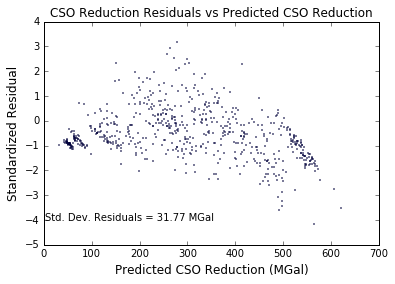

In [96]:
# Generate Residuals Plot for FILTERED Annual CSO Volumes vs reduced number of subcatchments
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# First, transpose results['numLists']:
xVals = greenedAcresFilteredTranspose
#print list(xVals[1])
numFilteredVariables = len(greenedAcresFiltered)
betaZero = stats.params[numFilteredVariables]
yPredicted = []
for x in xVals:
    i = 0
    yval = betaZero
    for beta in stats.params:
        yval += beta*x[i]
        i += 1
        if i == numFilteredVariables:
            break
    yPredicted.append(yval/1e6)  # convert to 10^6 Gal
residuals = []
csoReductionFilteredMgal = [x / 1e6 for x in csoReductionFiltered]
i = 0
for ySWMM in csoReductionFilteredMgal:
    #print ySWMM
    resid = ySWMM - yPredicted[i]  # Residual in 10^6 Gal
    residuals.append(resid)
    i+=1
stdDevResiduals = np.std(residuals, ddof=1) #ddof=1 for SAMPLE std. dev.
standardizedResiduals = [x / stdDevResiduals for x in residuals]
(fig, ax1) = plt.subplots()
plt.title("CSO Reduction Residuals vs Predicted CSO Reduction")
ax1.plot(yPredicted,standardizedResiduals,'ko',color = 'b',markersize = 1)
ax1.set_xlabel("Predicted CSO Reduction (MGal)",fontsize=12)
#ax1.set_ylabel("Residual (MGal)",fontsize=12)
ax1.set_ylabel("Standardized Residual",fontsize=12)
stdDevText = "Std. Dev. Residuals = %0.2f MGal" % stdDevResiduals
ax1.text(2,-4,stdDevText)


In [97]:
# Multivariable Regression for Annual Runoff VOLUME Reductions vs Filtered PWD Wingohocking subcatchments
import numpy as np
import statsmodels.api as sm

def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    statistics = sm.OLS(y, X).fit()
    return statistics

stats = reg_m(runoffVolumeReductionFiltered,greenedAcresFiltered)
print "Exact r-squared:"
print stats.rsquared
print stats.summary()
print stats.params
      

Exact r-squared:
0.974219217562
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1065.
Date:                Fri, 06 Jan 2017   Prob (F-statistic):               0.00
Time:                        17:59:31   Log-Likelihood:                -12214.
No. Observations:                 643   AIC:                         2.447e+04
Df Residuals:                     620   BIC:                         2.458e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1          9.674e+0

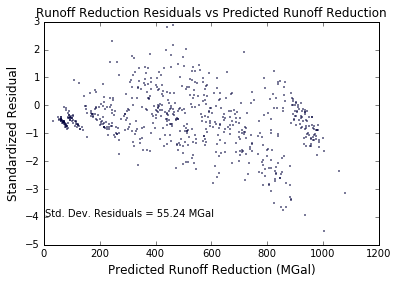

In [99]:
# Generate Residuals Plot for FILTERED Annual RUNOFF Volumes vs reduced number of subcatchments
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# First, transpose results['numLists']:
xVals = greenedAcresFilteredTranspose
#print list(xVals[1])
numFilteredVariables = len(greenedAcresFiltered)
betaZero = stats.params[numFilteredVariables]
yPredicted = []
for x in xVals:
    i = 0
    yval = betaZero
    for beta in stats.params:
        yval += beta*x[i]
        i += 1
        if i == numFilteredVariables:
            break
    yPredicted.append(yval/1e6)  # convert to 10^6 Gal
residuals = []
runoffVolumeReductionFilteredMgal = [x / 1e6 for x in runoffVolumeReductionFiltered]
i = 0
for ySWMM in runoffVolumeReductionFilteredMgal:
    #print ySWMM
    resid = ySWMM - yPredicted[i]  # Residual in 10^6 Gal
    residuals.append(resid)
    i+=1
stdDevResiduals = np.std(residuals, ddof=1) #ddof=1 for SAMPLE std. dev.
standardizedResiduals = [x / stdDevResiduals for x in residuals]
(fig, ax1) = plt.subplots()
ax1.plot(yPredicted,standardizedResiduals,'ko',color = 'b',markersize = 1)
plt.title("Runoff Reduction Residuals vs Predicted Runoff Reduction")
ax1.set_xlabel("Predicted Runoff Reduction (MGal)",fontsize=12)
#ax1.set_ylabel("Residual (MGal)",fontsize=12)
ax1.set_ylabel("Standardized Residual",fontsize=12)
stdDevText = "Std. Dev. Residuals = %0.2f MGal" % stdDevResiduals
ax1.text(2,-4,stdDevText)

In [7]:
import yaml
#from swmm_run_cso import *
from swmm_objects import *
from swmm_read_cso_time_series import *
swmmInpFile = "wingohocking_PWD.inp"  # initial SWMM .inp file
lidListFile = "PWD_wingo_Rain_Barrel_and_Morris_LID_List.yaml"
infile = open(swmmInpFile,'r')
swmmInpStr = infile.readlines()
infile.close()
(section_names,sections) = read_inp(swmmInpStr)
model = swmm_model("Model",section_names,sections)
f = open(lidListFile,'r')   # Read the LID parameters used to calculate [LID_USAGE]
lidList = yaml.load(f)  # list of dicts, one for each line in [LID_USAGE]
f.close()
#lid = 0
#for lidUsed in lidList:
    
model.getSubcatchmentSlope("TT14-574_shed")

5.80435